In [1]:
import torch
from datasets import load_dataset
from transformers import DistilBertTokenizer
from collections import Counter
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# --- CONFIGURATION ---
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 32

# --- 1. DEFINE THE MAPPING (Corrected and Expanded) ---
emotion_to_zone_map = {
    # Calm Zone (0)
    'admiration': 'calm', 'amusement': 'calm', 'approval': 'calm', 'caring': 'calm', 
    'desire': 'calm', 'excitement': 'calm', 'gratitude': 'calm', 'joy': 'calm', 
    'love': 'calm', 'optimism': 'calm', 'pride': 'calm', 'relief': 'calm', 'neutral': 'calm',
    # Stressed Zone (1)
    'anger': 'stressed', 'annoyance': 'stressed', 'disapproval': 'stressed',
    'disgust': 'stressed', 'confusion': 'stressed', 'curiosity': 'stressed', 'surprise': 'stressed',
    # Overwhelmed Zone (2)
    'sadness': 'overwhelmed', 'fear': 'overwhelmed', 'disappointment': 'overwhelmed',
    'embarrassment': 'overwhelmed', 'grief': 'overwhelmed', 'nervousness': 'overwhelmed',
    'remorse': 'overwhelmed'
}
zone_to_id = {'calm': 0, 'stressed': 1, 'overwhelmed': 2}


# --- 2. PREPROCESSING FUNCTION (Corrected) ---
def map_emotions_to_zone(example):
    """
    Maps a GoEmotions example to a single zone ID by checking individual emotion columns.
    Prioritizes the highest-stress zone in case of conflict.
    """
    present_zones = set()
    # Iterate through the emotions we have defined in our map
    for emotion, zone in emotion_to_zone_map.items():
        # Check if the emotion column exists in the example and is marked as 1
        if emotion in example and example[emotion] == 1:
            present_zones.add(zone)
    
    # Prioritization: Overwhelmed > Stressed > Calm
    if 'overwhelmed' in present_zones:
        final_zone = 'overwhelmed'
    elif 'stressed' in present_zones:
        final_zone = 'stressed'
    elif 'calm' in present_zones:
        final_zone = 'calm'
    else:
        # Fallback to calm if no mappable emotions are found for this example
        final_zone = 'calm'
        
    return {'zone': zone_to_id[final_zone], 'text': example['text']}

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    print("🚀 Starting Data Preparation...")

    # Load GoEmotions dataset from Hugging Face
    # --- Subsample for a quick scoping run ---
    raw_datasets = load_dataset("go_emotions", "raw")
    # PERCENT_TO_USE = 0.15
    # num_samples = int(len(raw_datasets['train']) * PERCENT_TO_USE)
    # raw_datasets['train'] = raw_datasets['train'].select(range(num_samples))
    # print(f"\n🔪 SCOPING RUN ACTIVE: Training data sliced to {num_samples} samples ({PERCENT_TO_USE:.0%})\n")
    print(f"✅ Raw dataset loaded. Train size: {len(raw_datasets['train'])}")

    # Apply the mapping function to create our 3-zone dataset
    mapped_datasets = raw_datasets.map(map_emotions_to_zone, remove_columns=raw_datasets['train'].column_names)
    print("✅ Emotion labels mapped to our 3 zones.")

    # Calculate class distribution and weights for the loss function
    train_labels = mapped_datasets['train']['zone']
    class_counts = Counter(train_labels)
    
    print("\n--- Class Distribution (Training Set) ---")
    total_samples = len(train_labels)
    for zone_id, count in sorted(class_counts.items()):
        zone_name = [k for k, v in zone_to_id.items() if v == zone_id][0]
        print(f"Zone '{zone_name}' (ID {zone_id}): {count} samples ({count/total_samples:.2%})")

    # Calculate weights for weighted loss function
    class_weights = [total_samples / class_counts[i] for i in sorted(class_counts.keys())]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
    print("\n✅ Calculated Class Weights for Loss Function:")
    print(class_weights_tensor)
    print("---\n")

    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

    # Tokenize the entire dataset
    tokenized_datasets = mapped_datasets.map(tokenize_function, batched=True)
    
    # Remove unnecessary columns and set format to PyTorch
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])
    tokenized_datasets = tokenized_datasets.rename_column("zone", "labels")
    tokenized_datasets.set_format("torch")
    print("✅ Datasets tokenized and formatted for PyTorch.")

    # Create DataLoaders
    # --- Create DataLoaders by splitting the 'train' set ---
    print("\nSplitting the 'train' dataset into train/validation sets (90/10)...")

    # Split the training dataset
    train_val_split = tokenized_datasets['train'].train_test_split(test_size=0.1, shuffle=True, seed=42)
    train_dataset = train_val_split['train']
    val_dataset = train_val_split['test'] # .train_test_split names the validation set 'test'

    print(f"✅ New train size: {len(train_dataset)}, New validation size: {len(val_dataset)}")

# Create the DataLoaders from our new splits
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    print(f"\n✅ DataLoaders created. Batch size: {BATCH_SIZE}")
    print(f"Total training batches: {len(train_dataloader)}")
    print(f"Total validation batches: {len(val_dataloader)}")

    print(f"\n✅ DataLoaders created. Batch size: {BATCH_SIZE}")
    print(f"Total training batches: {len(train_dataloader)}")
    print(f"Total validation batches: {len(val_dataloader)}")

    print("\nData preparation complete. Ready for training. 💪")

🚀 Starting Data Preparation...
✅ Raw dataset loaded. Train size: 211225
✅ Emotion labels mapped to our 3 zones.

--- Class Distribution (Training Set) ---
Zone 'calm' (ID 0): 137158 samples (64.93%)
Zone 'stressed' (ID 1): 51043 samples (24.17%)
Zone 'overwhelmed' (ID 2): 23024 samples (10.90%)

✅ Calculated Class Weights for Loss Function:
tensor([1.5400, 4.1382, 9.1741])
---



KeyboardInterrupt: 

## Training Script

✅ Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting training...


Epoch 1/3:   0%|          | 0/892 [00:00<?, ?it/s]

🔥 Epoch 1/3 | Average Training Loss: 0.6720


Epoch 2/3:   0%|          | 0/892 [00:00<?, ?it/s]

🔥 Epoch 2/3 | Average Training Loss: 0.5736


Epoch 3/3:   0%|          | 0/892 [00:00<?, ?it/s]

🔥 Epoch 3/3 | Average Training Loss: 0.4679
✅ Training complete.

📊 Evaluating model on the validation set...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


--- FINAL RESULTS ---
Accuracy: 0.7163
Macro F1-Score: 0.6248

Classification Report:
              precision    recall  f1-score   support

        calm       0.80      0.83      0.81      2022
    stressed       0.58      0.49      0.54       792
 overwhelmed       0.50      0.55      0.52       355

    accuracy                           0.72      3169
   macro avg       0.63      0.62      0.62      3169
weighted avg       0.71      0.72      0.71      3169



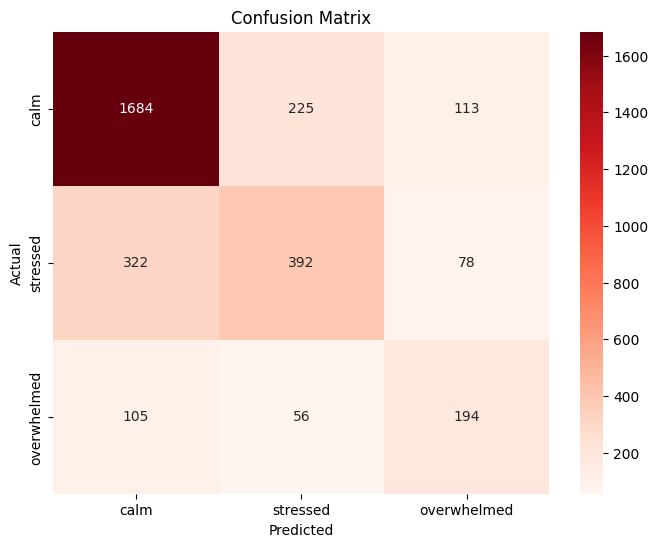

----------------------



In [ ]:
import torch
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION (from previous script) ---
NUM_EPOCHS = 3
LEARNING_RATE = 5e-5

# --- 1. MODEL & OPTIMIZER SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(zone_to_id))
model.to(device)

# Use the class_weights_tensor we calculated during data prep
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- 2. TRAINING LOOP ---
print("🚀 Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"🔥 Epoch {epoch + 1}/{NUM_EPOCHS} | Average Training Loss: {avg_train_loss:.4f}")

print("✅ Training complete.")

# --- 3. EVALUATION ---
print("\n📊 Evaluating model on the validation set...")
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# --- 4. REPORT METRICS ---
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='macro')
class_names = [zone for zone, _ in sorted(zone_to_id.items(), key=lambda item: item[1])]

print("\n--- FINAL RESULTS ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("----------------------\n")

## EDA

### 1. Zone Distribution Analysis (The Imbalance Plot)

C:\Users\Hp\AppData\Local\Temp\ipykernel_3456\2065011227.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=zone_names, order=['calm', 'stressed', 'overwhelmed'], palette='viridis')


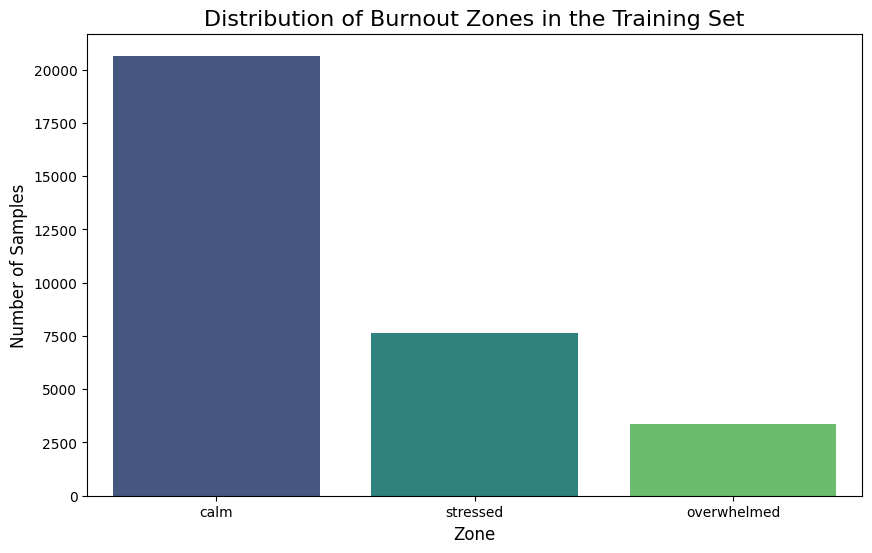

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'mapped_datasets' is your dataset after mapping zones
# and 'zone_to_id' is your dictionary {'calm': 0, ...}

# Get the labels from the full training dataset before we split it
full_train_labels = mapped_datasets['train']['zone']
id_to_zone = {v: k for k, v in zone_to_id.items()}
zone_names = [id_to_zone[label_id] for label_id in full_train_labels]

plt.figure(figsize=(10, 6))
sns.countplot(x=zone_names, order=['calm', 'stressed', 'overwhelmed'], palette='viridis')
plt.title('Distribution of Burnout Zones in the Training Set', fontsize=16)
plt.xlabel('Zone', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.show()

### 2. N-gram Analysis (The "Topic" Words)

This analysis answers the question: "What words or phrases are most common in each zone?" It helps us understand the language of Calm vs. Stressed vs. Overwhelmed. We'll look at the top 10 bigrams (two-word phrases) for each category.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Create a DataFrame for easier filtering
df = mapped_datasets['train'].to_pandas()

def get_top_n_bigrams(corpus, n=10):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for zone_name, zone_id in zone_to_id.items():
    print(f"\n--- Top 10 Bigrams for '{zone_name.upper()}' Zone ---")
    zone_df = df[df['zone'] == zone_id]
    top_bigrams = get_top_n_bigrams(zone_df['text'])
    for bigram, freq in top_bigrams:
        print(f"{bigram}: {freq}")


--- Top 10 Bigrams for 'CALM' Zone ---
looks like: 162
good luck: 112
feel like: 95
don know: 94
sounds like: 91
don think: 69
ve seen: 62
just like: 47
makes sense: 47
didn know: 44

--- Top 10 Bigrams for 'STRESSED' Zone ---
don know: 79
don think: 51
looks like: 44
ve seen: 35
feel like: 31
didn know: 26
look like: 24
sounds like: 24
don want: 23
don like: 23

--- Top 10 Bigrams for 'OVERWHELMED' Zone ---
feel like: 30
don know: 20
sounds like: 20
sorry loss: 20
don think: 19
feel bad: 19
looks like: 17
ve seen: 16
really bad: 16
sorry happened: 15


### 3. Text Length Analysis

This plot helps us see if there's a correlation between the length of a post and its emotional zone. Are Overwhelmed posts typically longer rants, or are they short and sharp expressions of distress?

C:\Users\Hp\AppData\Local\Temp\ipykernel_3456\1796974114.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='zone', y='text_length', data=df, order=[0, 1, 2], palette='magma')


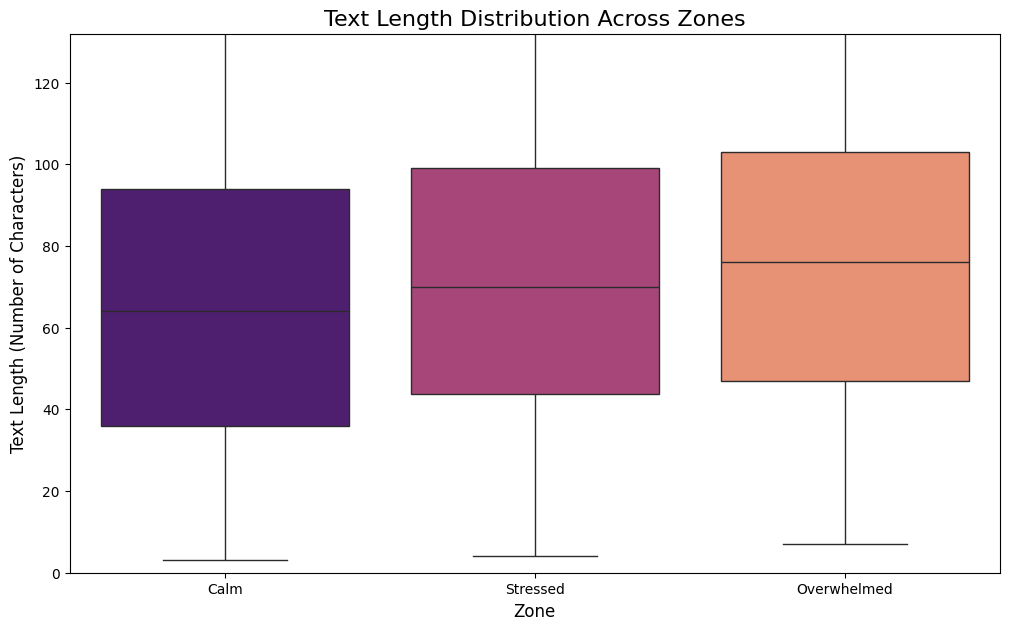

In [ ]:
# Use the same DataFrame 'df' from the N-gram analysis
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 7))
sns.boxplot(x='zone', y='text_length', data=df, order=[0, 1, 2], palette='magma')
plt.xticks(ticks=[0, 1, 2], labels=['Calm', 'Stressed', 'Overwhelmed'])
plt.title('Text Length Distribution Across Zones', fontsize=16)
plt.xlabel('Zone', fontsize=12)
plt.ylabel('Text Length (Number of Characters)', fontsize=12)
# Set a reasonable y-limit to exclude extreme outliers and make the box plot readable
plt.ylim(0, df['text_length'].quantile(0.95)) 
plt.show()

### 4. Topic Modeling with LDA (Discovering Latent Themes)

N-grams show us common phrases. Latent Dirichlet Allocation (LDA) goes deeper by finding the underlying abstract topics or themes within the text. For example, the 'Stressed' zone might have a topic cluster around "work," "deadlines," and "manager," and another around "exams," "study," and "grades." This adds a rich, qualitative narrative to our analysis.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# We'll use the DataFrame 'df' from the previous EDA
def perform_lda(data, n_topics=3, n_words=10):
    # Create a document-term matrix
    vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(data)
    
    # Build the LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)
    
    # Print the top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))

# Perform LDA on each zone
for zone_name, zone_id in zone_to_id.items():
    print(f"\n--- Latent Topics for '{zone_name.upper()}' Zone ---")
    zone_texts = df[df['zone'] == zone_id]['text']
    if not zone_texts.empty:
        perform_lda(zone_texts)


--- Latent Topics for 'CALM' Zone ---
Topic #1:
thank just oh great better like looks ve thought years
Topic #2:
like don just know time people love want ll think
Topic #3:
good love thanks right just lol happy yes did make

--- Latent Topics for 'STRESSED' Zone ---
Topic #1:
don know like really did think say mean people bad
Topic #2:
just fuck shit think guy want didn way fucking wrong
Topic #3:
like people just ve oh time hate man feel weird

--- Latent Topics for 'OVERWHELMED' Zone ---
Topic #1:
sorry don people like time just think thing bad oh
Topic #2:
just way know doesn actually like horrible hard makes right
Topic #3:
really just sad bad like sorry man thought feel going


### 5. Embedding Visualization with t-SNE (Mapping the Battlefield)

This is the most visually impressive analysis. We take the high-dimensional vector embeddings that DistilBERT creates for each text sample, crush them down into a 2D map using t-SNE, and plot them as a scatter plot.

If our zones are meaningful, we should see distinct clusters of colors (Calm in one area, Stressed in another, Overwhelmed in a third). It's direct visual proof that the concepts are separable in the model's "mind."


--- Generating Embeddings for t-SNE (this may take a moment)... ---
--- Running t-SNE... ---
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 10.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.010680
[t-SNE] KL divergence after 50 iterations with early exaggeration: 72.115547
[t-SNE] KL divergence after 300 iterations: 2.042564
--- Plotting t-SNE Results... ---


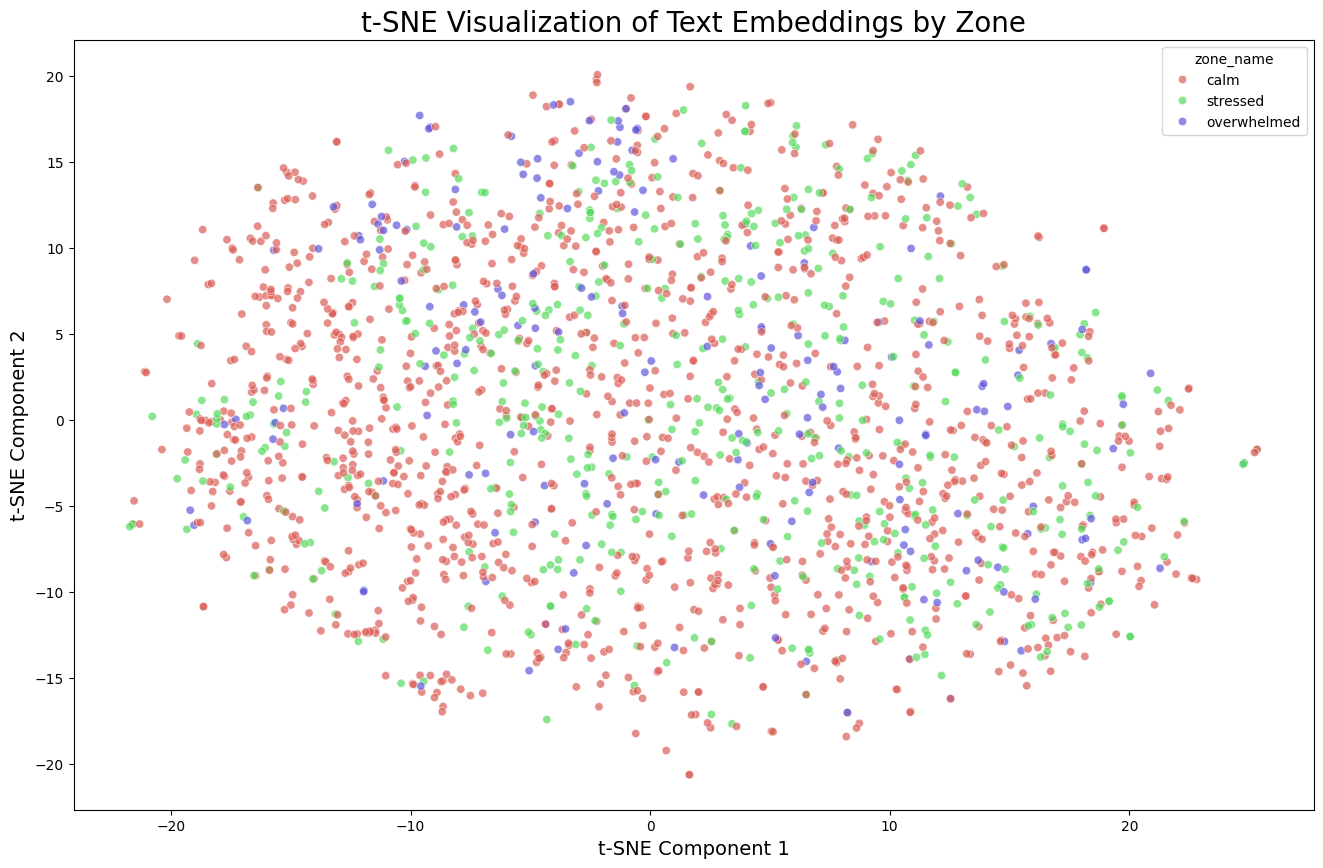

In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.manifold import TSNE
import numpy as np

# --- IMPORTANT: This is computationally intensive. We'll use a smaller sample. ---
sample_df = df.sample(n=2000, random_state=42)

# Load a pre-trained model for embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Use the [CLS] token's embedding as the sentence representation
    return model_output.last_hidden_state[:, 0, :].cpu().numpy()

print("\n--- Generating Embeddings for t-SNE (this may take a moment)... ---")
embeddings = get_embeddings(sample_df['text'].tolist())

print("--- Running t-SNE... ---")
tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

sample_df['tsne-2d-one'] = tsne_results[:,0]
sample_df['tsne-2d-two'] = tsne_results[:,1]
sample_df['zone_name'] = sample_df['zone'].map(id_to_zone)

print("--- Plotting t-SNE Results... ---")
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="zone_name",
    palette=sns.color_palette("hls", 3),
    data=sample_df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Visualization of Text Embeddings by Zone', fontsize=20)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.show()